In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from imblearn.over_sampling import SMOTE
import shap


ModuleNotFoundError: No module named 'shap'

In [ ]:
payment_df = pd.read_csv("payment_data.csv")
customer_df = pd.read_csv("customer_data.csv")

print(payment_df.head())
print(customer_df.head())


In [4]:
df = pd.merge(payment_df, customer_df, on='id', how='inner')

print(df.shape)
print(df.head())


(8250, 24)
         id  OVD_t1  OVD_t2  OVD_t3  OVD_sum  pay_normal  prod_code  \
0  58987402       0       0       0        0           1         10   
1  58995151       0       0       0        0           1          5   
2  58997200       0       0       0        0           2          5   
3  54988608       0       0       0        0           3         10   
4  54987763       0       0       0        0           2         10   

   prod_limit update_date  new_balance  ...   fea_2 fea_3   fea_4  fea_5  \
0     16500.0  04-12-2016          0.0  ...  1241.0     3   62000      2   
1         NaN  04-12-2016     588720.0  ...     NaN     2  126000      2   
2         NaN  04-12-2016     840000.0  ...  1376.0     1  150000      2   
3     37400.0  03-12-2016       8425.2  ...  1214.0     3   60000      2   
4         NaN  03-12-2016      15147.6  ...  1232.0     1   96000      2   

   fea_6  fea_7  fea_8  fea_9  fea_10      fea_11  
0     15      9     95      4   60023    1.000000  
1

In [5]:
print(df['label'].value_counts())


label
0    6863
1    1387
Name: count, dtype: int64


In [7]:
drop_cols = ['id', 'update_date', 'report_date']
df = df.drop(columns=[c for c in drop_cols if c in df.columns])

In [8]:
# Convert categorical features into numeric
df = pd.get_dummies(df, drop_first=True)

In [10]:
X = df.drop('label', axis=1)
y = df['label']

# Force numeric conversion (VERY IMPORTANT)
X = X.apply(pd.to_numeric, errors='coerce')
X = X.fillna(0)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [12]:
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:")
print(y_train.value_counts())

print("\nAfter SMOTE:")
print(y_train_smote.value_counts())


Before SMOTE:
label
0    5490
1    1110
Name: count, dtype: int64

After SMOTE:
label
0    5490
1    5490
Name: count, dtype: int64


In [13]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

In [14]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train_smote)

y_pred_lr = lr.predict(X_test_scaled)
y_prob_lr = lr.predict_proba(X_test_scaled)[:, 1]

print("LOGISTIC REGRESSION RESULTS")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

LOGISTIC REGRESSION RESULTS
Accuracy: 0.5921212121212122
ROC-AUC: 0.6225688300146456
              precision    recall  f1-score   support

           0       0.87      0.60      0.71      1373
           1       0.22      0.57      0.32       277

    accuracy                           0.59      1650
   macro avg       0.55      0.58      0.51      1650
weighted avg       0.76      0.59      0.64      1650



In [15]:
dt = DecisionTreeClassifier(max_depth=6, random_state=42)
dt.fit(X_train_smote, y_train_smote)

y_pred_dt = dt.predict(X_test)
y_prob_dt = dt.predict_proba(X_test)[:, 1]

print("DECISION TREE RESULTS")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_dt))
print(classification_report(y_test, y_pred_dt))

DECISION TREE RESULTS
Accuracy: 0.706060606060606
ROC-AUC: 0.7694592199747056
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1373
           1       0.32      0.65      0.43       277

    accuracy                           0.71      1650
   macro avg       0.61      0.69      0.61      1650
weighted avg       0.81      0.71      0.74      1650



In [ ]:
explainer = shap.Explainer(lr, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Feature importance summary
shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X.columns
)


In [ ]:
shap.summary_plot(
    shap_values,
    features=X_test,
    feature_names=X.columns,
    plot_type="bar"
)


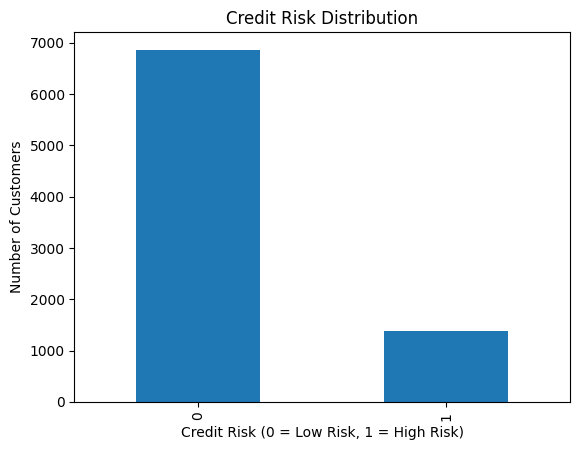

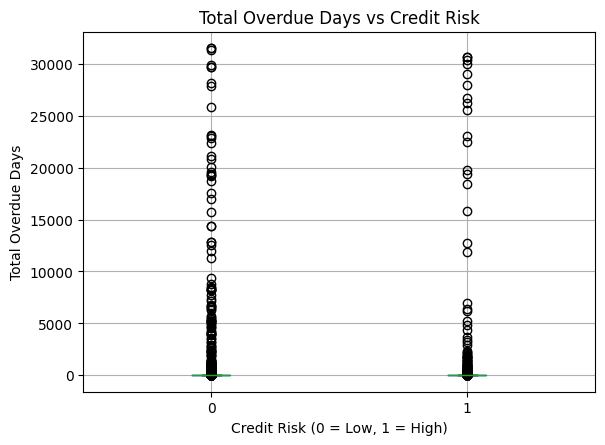

In [21]:
import matplotlib.pyplot as plt

df['label'].value_counts().plot(kind='bar')
plt.title("Credit Risk Distribution")
plt.xlabel("Credit Risk (0 = Low Risk, 1 = High Risk)")
plt.ylabel("Number of Customers")
plt.show()


df.boxplot(column='OVD_sum', by='label')
plt.title("Total Overdue Days vs Credit Risk")
plt.suptitle("")
plt.xlabel("Credit Risk (0 = Low, 1 = High)")
plt.ylabel("Total Overdue Days")
plt.show()


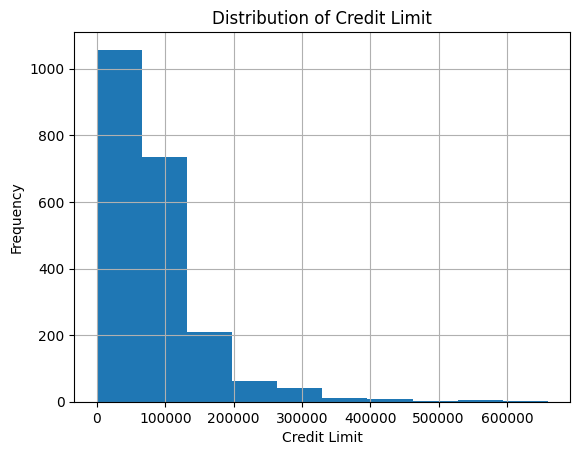

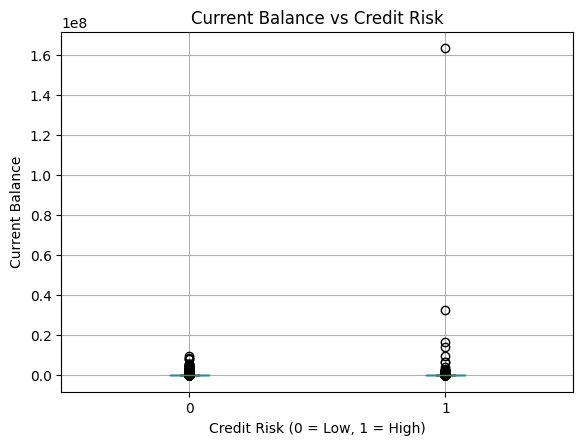

In [23]:
df['prod_limit'].hist()
plt.title("Distribution of Credit Limit")
plt.xlabel("Credit Limit")
plt.ylabel("Frequency")
plt.show()


df.boxplot(column='new_balance', by='label')
plt.title("Current Balance vs Credit Risk")
plt.suptitle("")
plt.xlabel("Credit Risk (0 = Low, 1 = High)")
plt.ylabel("Current Balance")
plt.show()


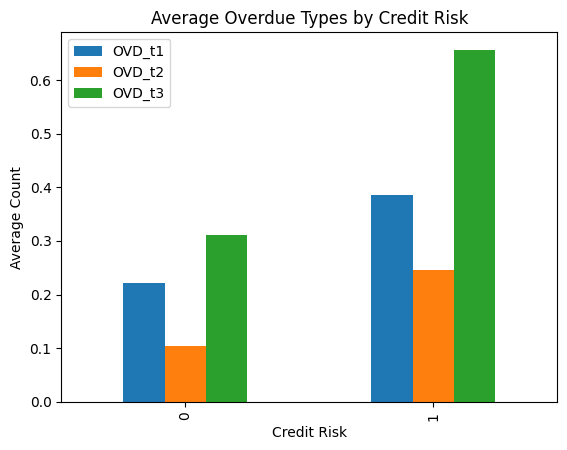

In [24]:
df.groupby('label')[['OVD_t1','OVD_t2','OVD_t3']].mean().plot(kind='bar')
plt.title("Average Overdue Types by Credit Risk")
plt.xlabel("Credit Risk")
plt.ylabel("Average Count")
plt.show()
